In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/34000-medicine-details/dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

In [3]:

df=pd.read_csv("/kaggle/input/34000-medicine-details/dataset.csv")
df.head(5)

,web-scraper-order,web-scraper-start-url,Links,Links-href,Name,Uses,Price,Composition,Side_effects,Alcohol,...,Kidney,Liver,Poor,Excellent,Average,How_to_use,Status,manufacturer,Unit Quantity,Unit Type
0,1698600802-3,https://www.1mg.com/drugs-all-medicines?page=50,Aceloflam Plus TabletMRP₹94Prescription Requir...,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,₹86.5,Aceclofenac (100mg) + Paracetamol (325mg),NauseaVomitingStomach pain/epigastric painLoss...,CAUTION,...,NaN,NaN,100%,NaN,NaN,Aceloflam Plus Tablet is a combination of two ...,₹86.5Inclusive of all taxesMRP₹94 8% OFF15 ta...,Alkem Laboratories Ltd,NaN,Tablet
1,1698600802-3,https://www.1mg.com/drugs-all-medicines?page=50,Aceloflam Plus TabletMRP₹94Prescription Requir...,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,₹86.5,Aceclofenac (100mg) + Paracetamol (325mg),NauseaVomitingStomach pain/epigastric painLoss...,CAUTION,...,NaN,NaN,100%,NaN,NaN,Aceloflam Plus Tablet is a combination of two ...,₹86.5Inclusive of all taxesMRP₹94 8% OFF15 ta...,Alkem Laboratories Ltd,NaN,Tablet
2,1698606345-964,https://www.1mg.com/drugs-all-medicines?page=18,Aceloflam Plus TabletMRP₹63Prescription Requir...,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,₹159.68,Aceclofenac (100mg) + Paracetamol (325mg),NauseaVomitingStomach pain/epigastric painLoss...,CAUTION,...,NaN,NaN,58%,25%,17%,Aceloflam Plus Tablet is a combination of two ...,₹40.86₹63Get 35% OFF₹37.23+ free shipping and ...,Alkem Laboratories Ltd,NaN,Tablet
3,1698606345-964,https://www.1mg.com/drugs-all-medicines?page=18,Aceloflam Plus TabletMRP₹63Prescription Requir...,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,₹159.68,Aceclofenac (100mg) + Paracetamol (325mg),NauseaVomitingStomach pain/epigastric painLoss...,CAUTION,...,NaN,NaN,58%,25%,17%,Aceloflam Plus Tablet is a combination of two ...,₹40.86₹63Get 35% OFF₹37.23+ free shipping and ...,Alkem Laboratories Ltd,NaN,Tablet
4,1698600815-7,https://www.1mg.com/drugs-all-medicines?page=50,Adriamycin 50mg InjectionMRP₹889Prescription R...,https://www.1mg.com/drugs/adriamycin-50mg-inje...,Adriamycin 50mg Injection,Cancer,₹282,Doxorubicin (Plain) (50mg),VomitingAllergic reactionNauseaMouth soreHair ...,CONSULT YOUR DOCTOR,...,SAFE IF PRESCRIBED,CAUTION,100%,NaN,NaN,Adriamycin 50mg Injection is an anti-cancer me...,₹736.2₹889Get 17% OFF₹670.76+ free shipping an...,Pfizer Ltd,50.0,Injection


In [4]:
df['Price'] = df['Price'].str.replace('₹', '')

In [5]:
df = df[~df['web-scraper-start-url'].str.contains(r'page=[4][4-9]|50')]
df.shape

(30566, 23)

In [6]:
def split_side_effect(text):
    if not isinstance(text, str):
        return []  
    pattern = r'(?<=[a-z )])(?=[A-Z])'
    side_effects = re.split(pattern, text)
    side_effects = [effect.strip() for effect in side_effects if effect.strip()]
    return side_effects
df['Side_effects'] = df['Side_effects'].apply(split_side_effect)

In [7]:
def clean_status(status_text):
    if isinstance(status_text, str):
        pattern = r"(available|sold out)"
        match = re.search(pattern, status_text, re.I)
        if match:
            return match.group(0).lower()
        else:
            return "Not found"
    else:
        return "Not found"
df['Status'] = df['Status'].apply(clean_status)

In [8]:
df.isnull().sum()

web-scraper-order            0
web-scraper-start-url        0
Links                        0
Links-href                   0
Name                         0
Uses                       139
Price                     8523
Composition                  0
Side_effects                 0
Alcohol                   4346
Pregnancy                  156
Breast feeding            1274
Driving                   4844
Kidney                    5679
Liver                     5679
Poor                     15151
Excellent                17663
Average                  20836
How_to_use                  31
Status                       0
manufacturer                 0
Unit Quantity            12089
Unit Type                 1836
dtype: int64

In [9]:
df.drop('Poor', axis=1, inplace=True)
df.drop('Excellent', axis=1, inplace=True)
df.drop('Average', axis=1, inplace=True)

In [10]:
df.drop('web-scraper-order', axis=1, inplace=True)
df.drop('web-scraper-start-url', axis=1, inplace=True)
df.drop('Links', axis=1, inplace=True)


In [11]:
df["Alcohol"].fillna("No_impact", inplace=True)
df["Pregnancy"].fillna("No_impact", inplace=True)
df["Breast feeding"].fillna("No_impact", inplace=True)
df["Driving"].fillna("No_impact", inplace=True)
df["Kidney"].fillna("No_impact", inplace=True)
df["Liver"].fillna("No_impact", inplace=True)

df['Alcohol'] = df['Alcohol'].str.lower()
df['Pregnancy'] = df['Pregnancy'].str.lower()
df['Breast feeding'] = df['Breast feeding'].str.lower()
df['Driving'] = df['Driving'].str.lower()
df['Kidney'] = df['Kidney'].str.lower()
df['Liver'] = df['Liver'].str.lower()

/tmp/ipykernel_36/2355572095.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Alcohol"].fillna("No_impact", inplace=True)
/tmp/ipykernel_36/2355572095.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [12]:
df.head()

,Links-href,Name,Uses,Price,Composition,Side_effects,Alcohol,Pregnancy,Breast feeding,Driving,Kidney,Liver,How_to_use,Status,manufacturer,Unit Quantity,Unit Type
2,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,159.68,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",caution,caution,no_impact,no_impact,no_impact,no_impact,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,NaN,Tablet
3,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,159.68,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",caution,caution,no_impact,no_impact,no_impact,no_impact,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,NaN,Tablet
8,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",caution,consult your doctor,consult your doctor,safe,caution,caution,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
9,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",caution,consult your doctor,consult your doctor,safe,caution,caution,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
13,https://www.1mg.com/drugs/abaxis-5mg-tablet-79...,Abaxis 5mg Tablet,Treatment and prevention of Blood clots,524,Apixaban (5mg),"[Anemia (low number of red blood cells), Blood...",caution,consult your doctor,consult your doctor,safe,caution,caution,Abaxis 5mg Tablet is a novel oral anticoagulan...,sold out,Intas Pharmaceuticals Ltd,5.0,Tablet


In [13]:
df.isnull().sum()

Links-href            0
Name                  0
Uses                139
Price              8523
Composition           0
Side_effects          0
Alcohol               0
Pregnancy             0
Breast feeding        0
Driving               0
Kidney                0
Liver                 0
How_to_use           31
Status                0
manufacturer          0
Unit Quantity     12089
Unit Type          1836
dtype: int64

In [14]:
df['Price'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_36/2130040308.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_36/2130040308.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Price'].fillna(method='ffill', inplace=True)


In [15]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # แปลงเป็นตัวเลข (หากเป็นข้อความ)
df['Price'] = df['Price'].round(0).astype(int) 

In [16]:
df['Price'].isnull().sum()

0

In [17]:
df['Alcohol'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Alcohol'].replace(['no_impact', 'safe','safe if prescribed'], 'safe', inplace=True)

df['Pregnancy'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Pregnancy'].replace(['no_impact','safe if prescribed'], 'safe', inplace=True)

df['Breast feeding'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Breast feeding'].replace(['no_impact','safe if prescribed'], 'safe', inplace=True)

df['Driving'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Driving'].replace(['no_impact','safe if prescribed','not relevant'], 'safe', inplace=True)

df['Kidney'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Kidney'].replace(['no_impact','safe if prescribed'], 'safe', inplace=True)

df['Liver'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
df['Liver'].replace(['no_impact','safe if prescribed'], 'safe', inplace=True)

/tmp/ipykernel_36/4081510368.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Alcohol'].replace(['caution', 'consult your doctor'], 'unsafe', inplace=True)
/tmp/ipykernel_36/4081510368.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

In [18]:
df['Unit Quantity'].fillna(1,inplace=True)

/tmp/ipykernel_36/2280525654.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Unit Quantity'].fillna(1,inplace=True)


In [19]:
df.head()

,Links-href,Name,Uses,Price,Composition,Side_effects,Alcohol,Pregnancy,Breast feeding,Driving,Kidney,Liver,How_to_use,Status,manufacturer,Unit Quantity,Unit Type
2,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",unsafe,unsafe,safe,safe,safe,safe,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,1.0,Tablet
3,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",unsafe,unsafe,safe,safe,safe,safe,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,1.0,Tablet
8,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
9,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
13,https://www.1mg.com/drugs/abaxis-5mg-tablet-79...,Abaxis 5mg Tablet,Treatment and prevention of Blood clots,524,Apixaban (5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 5mg Tablet is a novel oral anticoagulan...,sold out,Intas Pharmaceuticals Ltd,5.0,Tablet


In [20]:
import requests
from bs4 import BeautifulSoup

# Function to convert HTTPS links to HTTP
def convert_to_http(link):
    if link.startswith('https://'):
        return link.replace('https://', 'http://')
    return link
def scrape_description(link):
    try:
        link = convert_to_http(link)
        response = requests.get(link)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the relevant description (assuming it's within a <p> tag or similar)
        description = soup.find('p').get_text(strip=True)
        return description
    except Exception as e:
        print(f"Error scraping {link}: {e}")
        return None


In [21]:
df.head(5)

,Links-href,Name,Uses,Price,Composition,Side_effects,Alcohol,Pregnancy,Breast feeding,Driving,Kidney,Liver,How_to_use,Status,manufacturer,Unit Quantity,Unit Type
2,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",unsafe,unsafe,safe,safe,safe,safe,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,1.0,Tablet
3,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",unsafe,unsafe,safe,safe,safe,safe,Aceloflam Plus Tablet is a combination of two ...,available,Alkem Laboratories Ltd,1.0,Tablet
8,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
9,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 2.5mg Tablet is a novel oral anticoagul...,sold out,Intas Pharmaceuticals Ltd,2.0,Tablet
13,https://www.1mg.com/drugs/abaxis-5mg-tablet-79...,Abaxis 5mg Tablet,Treatment and prevention of Blood clots,524,Apixaban (5mg),"[Anemia (low number of red blood cells), Blood...",unsafe,unsafe,unsafe,safe,unsafe,unsafe,Abaxis 5mg Tablet is a novel oral anticoagulan...,sold out,Intas Pharmaceuticals Ltd,5.0,Tablet


In [22]:
df.dropna(inplace=True)

In [23]:
df.isnull().sum()

Links-href        0
Name              0
Uses              0
Price             0
Composition       0
Side_effects      0
Alcohol           0
Pregnancy         0
Breast feeding    0
Driving           0
Kidney            0
Liver             0
How_to_use        0
Status            0
manufacturer      0
Unit Quantity     0
Unit Type         0
dtype: int64

In [24]:
!pip install rapidfuzz joblib redis
import pandas as pd
import re

# # Function to extract drug names from the composition
def extract_drug_names(composition):
    pattern = r'([A-Za-z\s]+?)\(\d+mg\)'  # Adjust pattern as needed
    matches = re.findall(pattern, composition)
    return [match.strip() for match in matches]

# Apply the function to the 'Composition' column
df['composition'] = df['Composition'].apply(extract_drug_names)
df['composition'] = df['composition'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 14.1 MB/s eta 0:00:00


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



# TF-IDF Vectorizer for textual features
vectorizer = TfidfVectorizer()
tfidf_composition = vectorizer.fit_transform(df['composition'])
tfidf_name = vectorizer.fit_transform(df['Name'])

def get_recommendations(input_query, search_type='name', top_n=3):
    if search_type == 'name':
        # Search by Name
        input_tfidf = vectorizer.transform([input_query])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_name)
    elif search_type == 'composition':
        # Search by Composition
        input_tfidf = vectorizer.transform([input_query])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_composition)
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")
    
    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim.flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get indices of top N recommendations
    top_indices = [i[0] for i in sim_scores[:top_n]]
    recommendations = df.iloc[top_indices]
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']]

# Test the recommender
input_query = 'Aceloflam Plus Tablet'  # or a composition string
search_type = 'name'  # or 'composition'

recommended_drugs = get_recommendations(input_query, search_type=search_type, top_n=10)

print("Recommended Drugs:")
from IPython.display import display
print(display(recommended_drugs))


Recommended Drugs:


,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
2,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",available,Alkem Laboratories Ltd
3,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",available,Alkem Laboratories Ltd
870,https://www.1mg.com/drugs/aceloflam-sp-tablet-...,Aceloflam SP Tablet,Pain relief,110,Aceclofenac (100mg) + Paracetamol (325mg) + Se...,"[Nausea, Vomiting, Stomach pain, Indigestion, ...",sold out,Alkem Laboratories Ltd
33126,https://www.1mg.com/drugs/x-plus-syrup-245853,X Plus Syrup,Cough with mucus,30,Ambroxol (NA) + Guaifenesin (NA) + Terbutaline...,"[Nausea, Vomiting, Diarrhea, Dizziness, Headac...",sold out,Aaron Pharmaceuticals Pvt Ltd
28260,https://www.1mg.com/drugs/t-plus-eye-drop-313807,T Plus Eye Drop,Eye examination,55,Phenylephrine (5% w/v) + Tropicamide (0.8% w/v),"[Eye pain, Stinging in the eyes, Blurred visio...",sold out,Senses Pharmaceuticals Ltd
30105,https://www.1mg.com/drugs/ultra-plus-tablet-13...,Ultra Plus Tablet,Pain relief,53,Paracetamol/Acetaminophen (325mg) + Tramadol...,"[Nausea, Vomiting, Constipation, Weakness, Diz...",Not found,Icon Pharma & Surgicals Pvt Ltd
9492,https://www.1mg.com/drugs/g-on-plus-tablet-568725,G-ON Plus Tablet,Indigestion Bloating,92,Pancreatin (175mg) + Simethicone (50mg) + char...,"[Nausea, Stomach pain, Bloating, Constipation,...",sold out,Gamete Pharma Pvt Ltd
10591,https://www.1mg.com/drugs/gudcef-plus-tablet-1...,Gudcef Plus Tablet,Bacterial infections,70,Cefpodoxime Proxetil (200mg) + Ofloxacin (200mg),"[Nausea, Vomiting, Diarrhea, Stomach pain, Hea...",available,Mankind Pharma Ltd
287,https://www.1mg.com/drugs/ace-plus-tablet-418644,Ace Plus Tablet,Pain relief,91,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",sold out,Maxis Healthcare
5960,https://www.1mg.com/drugs/dytor-plus-5-tablet-...,Dytor Plus 5 Tablet,Treatment of Edema,280,Spironolactone (50mg) + Torasemide (5mg),"[Dizziness, Frequent urge to urinate, Headache...",available,Cipla Ltd


None


In [26]:
# Combine Name and Composition for TF-IDF Vectorization
df['Combined'] = df['Name'] + ' ' + df['composition']

# TF-IDF Vectorizer for combined features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Combined'])

def get_recommendations(input_query, search_type='name', top_n=3):
    if search_type == 'name':
        # Search by Name
        input_query_combined = input_query + ' '  # Add a space to match the combined format
        input_tfidf = vectorizer.transform([input_query_combined])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_matrix)
    elif search_type == 'composition':
        # Search by Composition
        input_tfidf = vectorizer.transform([input_query])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_matrix)
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")
    
    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim.flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get indices of top N recommendations
    top_indices = [i[0] for i in sim_scores[:top_n]]
    recommendations = df.iloc[top_indices]
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']]

# Test the recommender
input_query = 'Paracetamol'  # or a composition string
search_type = 'composition'  # or 'name'

recommended_drugs = get_recommendations(input_query, search_type=search_type, top_n=10)

print("Recommended Drugs:")
from IPython.display import display
print(display(recommended_drugs))

Recommended Drugs:


,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
9526,https://www.1mg.com/drugs/genericart-paracetam...,Genericart Paracetamol 500mg Tablet,Pain reliefTreatment of Fever,10,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",sold out,Swast Aushadhi Seva Generic Medicine Store
33212,https://www.1mg.com/drugs/xtpara-tablet-sr-477469,Xtpara Tablet SR,Pain relief Fever,63,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],sold out,Unichem Laboratories Ltd
23340,https://www.1mg.com/drugs/paracetamol-120mg-or...,Paracetamol 120mg Oral Suspension,Pain reliefTreatment of Fever,15,Paracetamol (120mg),"[Indigestion, Stomach pain, Nausea, Vomiting]",sold out,Ciron Drugs & Pharmaceuticals Pvt Ltd
12480,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],Not found,Innovcare Lifesciences Pvt Ltd
12481,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],Not found,Innovcare Lifesciences Pvt Ltd
12482,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],available,Innovcare Lifesciences Pvt Ltd
12483,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],available,Innovcare Lifesciences Pvt Ltd
23370,https://www.1mg.com/drugs/p-500-tablet-249829,P 500 Tablet,Pain reliefTreatment of Fever,13,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",available,Apex Laboratories Pvt Ltd
10136,https://www.1mg.com/drugs/genericart-paracetam...,Genericart Paracetamol 650mg Tablet,Pain reliefTreatment of Fever,20,Paracetamol (650mg),"[Stomach pain, Nausea, Vomiting]",sold out,Swast Aushadhi Seva Generic Medicine Store
23072,https://www.1mg.com/drugs/para-1000-sr-tablet-...,Para 1000-SR Tablet,Pain relief Fever,69,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],sold out,Himerus Medical Solution Llp


None


In [27]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.7/268.7 kB 3.8 MB/s eta 0:00:00 0:00:01


In [28]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import time

# Load the TinyBERT model from HuggingFace's sentence-transformers
model = SentenceTransformer('huawei-noah/TinyBERT_General_4L_312D')

# Assume df is your loaded dataset with relevant features like 'Name', 'Composition', etc.
# Ensure 'composition' is a string by joining lists if necessary
df['composition'] = df['composition'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Create a single text column combining relevant features for recommendations
df['combined_text'] = (
    df['Composition'].fillna('') + ' ' +
    df['Uses'].fillna('') + ' ' +
    df['Name'].fillna('') + ' ' +
    df['How_to_use'].fillna('') + ' ' +
    df['manufacturer'].fillna('') + ' ' +
    df['Unit Type'].fillna('') + ' ' +
    df['composition'].fillna('')
)

# Step 1: Generate embeddings only once and reuse
if 'combined_embeddings' not in df.columns:
    print("Generating embeddings...")
    # Encode all combined texts in a single batch and disable progress bar
    combined_embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=False)
    df['combined_embeddings'] = list(combined_embeddings)
    print("Embeddings generated.")
else:
    print("Embeddings already exist.")

# Convert embeddings to numpy array for similarity calculation
combined_embeddings = np.array(df['combined_embeddings'].tolist())

# Optimized Recommendation Function Using TinyBERT Embeddings
def get_recommendations_tinybert(input_drug_name, df_filtered, top_n=3):
    # Encode the input drug name without showing progress bar
    input_embedding = model.encode(input_drug_name, show_progress_bar=False)
    
    print(f"Input embedding for '{input_drug_name}' generated.")
    
    # Calculate cosine similarity between input embedding and the dataset embeddings
    cosine_similarities = cosine_similarity([input_embedding], combined_embeddings)[0]
    print("Cosine similarities computed.")
    
    # Get the top N recommendations excluding the input drug itself
    top_n = min(top_n, len(cosine_similarities) - 1)
    recommended_indices = np.argsort(cosine_similarities)[::-1][1:top_n+1]
    
    # Debug output for recommended indices
    print(f"Top {top_n} recommendation indices: {recommended_indices}")
    
    recommended_drugs = df_filtered.iloc[recommended_indices]
    
    # Return drug details including names, compositions, uses, and prices
    return recommended_drugs[['Name', 'Composition', 'Uses', 'Price']]

# Test the updated function
start_time = time.time()
recommended_drugs = get_recommendations_tinybert('Bravia-DSR Capsule', df, top_n=5)
end_time = time.time()

# Output results
print("Recommended Drugs:")
print(recommended_drugs)
print(f"Time taken for search: {end_time - start_time:.4f} seconds")


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating embeddings...
Embeddings generated.
Input embedding for 'Bravia-DSR Capsule' generated.
Cosine similarities computed.
Top 5 recommendation indices: [13919 14510 14273 13816 13706]
Recommended Drugs:
                      Name        Composition           Uses  Price
16837     Lurata 40 Tablet  Lurasidone (40mg)  Schizophrenia    160
17462    Luramax 40 Tablet  Lurasidone (40mg)  Schizophrenia    226
17218    Lurasid 40 Tablet  Lurasidone (40mg)  Schizophrenia    163
16731    Luramax 20 Tablet  Lurasidone (20mg)  Schizophrenia     92
16606  Luramax 80mg Tablet  Lurasidone (80mg)  Schizophrenia    119
Time taken for search: 0.0740 seconds


In [29]:
# Test the updated function
model = SentenceTransformer('huawei-noah/TinyBERT_General_4L_312D')
start_time = time.time()
recommended_drugs = get_recommendations_tinybert('Lurata ', df, top_n=5)
end_time = time.time()

# Output results
print("Recommended Drugs:")
print(recommended_drugs)
print(f"Time taken for search: {end_time - start_time:.4f} seconds")

Input embedding for 'Lurata ' generated.
Cosine similarities computed.
Top 5 recommendation indices: [ 5422  5896 14273 22575 15609]
Recommended Drugs:
                    Name         Composition  \
6517     Elicia 8 Tablet   Blonanserin (8mg)   
7024     Elicia 4 Tablet   Blonanserin (4mg)   
17218  Lurasid 40 Tablet   Lurasidone (40mg)   
27085  Seretra 80 Tablet  Seratrodast (80mg)   
18777    Meva SR Capsule  Mebeverine (200mg)   

                                        Uses  Price  
6517                     Schizophrenia Mania  36868  
7024                     Schizophrenia Mania    139  
17218                          Schizophrenia    163  
27085                                 Asthma    427  
18777  Treatment of Irritable bowel syndrome     24  
Time taken for search: 0.0447 seconds


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
pip install transformers torch


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [31]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load TinyBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Sample DataFrame (Replace this with your actual DataFrame)



# Combine 'Name' and 'Composition' for TF-IDF Vectorization
df['Combined'] = df['Name'] + ' ' + df['Composition']

# TF-IDF Vectorizer for combined features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Combined'])

def get_recommendations(input_query, search_type='name', top_n=3):
    if search_type == 'name':
        # Search by Name
        input_query_combined = input_query + ' '  # Add a space to match the combined format
        input_tfidf = vectorizer.transform([input_query_combined])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_matrix)
    elif search_type == 'composition':
        # Search by Composition
        input_tfidf = vectorizer.transform([input_query])
        cosine_sim = cosine_similarity(input_tfidf, tfidf_matrix)
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")
    
    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim.flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get indices of top N recommendations
    top_indices = [i[0] for i in sim_scores[:top_n]]
    recommendations = df.iloc[top_indices]
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']], sim_scores

### Evaluation Metrics Functions

def precision_at_k(ground_truth, recommendations, k):
    """
    Calculates Precision@K.
    
    Parameters:
    - ground_truth (set): Set of relevant item indices.
    - recommendations (list): List of recommended item indices.
    - k (int): Number of top recommendations to consider.
    
    Returns:
    - precision (float): Precision at K.
    """
    recommended_at_k = recommendations[:k]
    relevant_at_k = len(set(recommended_at_k) & ground_truth)
    return relevant_at_k / k

def recall_at_k(ground_truth, recommendations, k):
    """
    Calculates Recall@K.
    
    Parameters:
    - ground_truth (set): Set of relevant item indices.
    - recommendations (list): List of recommended item indices.
    - k (int): Number of top recommendations to consider.
    
    Returns:
    - recall (float): Recall at K.
    """
    recommended_at_k = recommendations[:k]
    relevant_at_k = len(set(recommended_at_k) & ground_truth)
    return relevant_at_at_k / len(ground_truth) if len(ground_truth) > 0 else 0

def f1_at_k(ground_truth, recommendations, k):
    """
    Calculates F1-Score@K.
    
    Parameters:
    - ground_truth (set): Set of relevant item indices.
    - recommendations (list): List of recommended item indices.
    - k (int): Number of top recommendations to consider.
    
    Returns:
    - f1 (float): F1-Score at K.
    """
    p = precision_at_k(ground_truth, recommendations, k)
    r = recall_at_k(ground_truth, recommendations, k)
    if p + r == 0:
        return 0
    return 2 * (p * r) / (p + r)

def mean_reciprocal_rank(ground_truth, recommendations):
    """
    Calculates Mean Reciprocal Rank (MRR).
    
    Parameters:
    - ground_truth (set): Set of relevant item indices.
    - recommendations (list): List of recommended item indices.
    
    Returns:
    - mrr (float): Mean Reciprocal Rank.
    """
    for i, rec in enumerate(recommendations):
        if rec in ground_truth:
            return 1 / (i + 1)
    return 0

def calculate_mse(predicted_scores, actual_scores):
    """
    Calculates Mean Squared Error (MSE).
    
    Parameters:
    - predicted_scores (list): List of predicted similarity scores.
    - actual_scores (list): List of actual relevance scores or ratings.
    
    Returns:
    - mse_value (float): Mean Squared Error.
    """
    return mean_squared_error(actual_scores, predicted_scores)

### Example Usage and Evaluation

# Example Input
input_query = 'Paracetamol'  # or a composition string
search_type = 'composition'  # or 'composition'
top_n = 3  # Number of recommendations

# Get Recommendations
recommended_drugs, sim_scores = get_recommendations(input_query, search_type=search_type, top_n=top_n)

print("Recommended Drugs:")
display(recommended_drugs)

### Evaluation

# **Note:** To evaluate the recommendations, you need a ground truth set of relevant items.
# This could be based on user interactions, expert knowledge, or any other relevant criteria.
# For demonstration purposes, we'll create a mock ground truth.

# Mock Ground Truth (Replace with your actual ground truth)
# Suppose for the input_query 'Paracetamol', the relevant drugs are 'Paracetamol' itself and 'Ibuprofen'
ground_truth_names = ['Paracetamol',]
ground_truth = set(df[df['Name'].isin(ground_truth_names)].index)

# Extract recommended indices
recommended_indices = list(recommended_drugs.index)

# Define K
k = top_n

# Calculate Metrics
precision = precision_at_k(ground_truth, recommended_indices, k)
recall = recall_at_k(ground_truth, recommended_indices, k)
f1 = f1_at_k(ground_truth, recommended_indices, k)
mrr = mean_reciprocal_rank(ground_truth, recommended_indices)

# For MSE, assuming actual relevance scores (binary: 1 for relevant, 0 for not)
# Create actual_scores based on ground_truth
actual_scores = [1 if idx in ground_truth else 0 for idx, _ in sim_scores[:top_n]]
predicted_scores = [score for _, score in sim_scores[:top_n]]
mse_value = calculate_mse(predicted_scores, actual_scores)

# Display Metrics
print(f"Precision@{k}: {precision:.2f}")
print(f"Recall@{k}: {recall:.2f}")
print(f"F1-Score@{k}: {f1:.2f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.2f}")
print(f"Mean Squared Error (MSE): {mse_value:.4f}")


Recommended Drugs:


,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
9526,https://www.1mg.com/drugs/genericart-paracetam...,Genericart Paracetamol 500mg Tablet,Pain reliefTreatment of Fever,10,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",sold out,Swast Aushadhi Seva Generic Medicine Store
23370,https://www.1mg.com/drugs/p-500-tablet-249829,P 500 Tablet,Pain reliefTreatment of Fever,13,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",available,Apex Laboratories Pvt Ltd
23340,https://www.1mg.com/drugs/paracetamol-120mg-or...,Paracetamol 120mg Oral Suspension,Pain reliefTreatment of Fever,15,Paracetamol (120mg),"[Indigestion, Stomach pain, Nausea, Vomiting]",sold out,Ciron Drugs & Pharmaceuticals Pvt Ltd


Precision@3: 0.00
Recall@3: 0.00
F1-Score@3: 0.00
Mean Reciprocal Rank (MRR): 0.00
Mean Squared Error (MSE): 0.2993


In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from IPython.display import display
from rapidfuzz import fuzz, process
import numpy as np

In [35]:
def get_recommendations_rapidfuzz(input_query, search_type='name', top_n=3, scorer=fuzz.token_sort_ratio):
    """
    Generates recommendations based on fuzzy matching using RapidFuzz.

    Parameters:
    - input_query (str): The search query input by the user.
    - search_type (str): The field to search in ('name' or 'composition').
    - top_n (int): The number of top recommendations to return.
    - scorer (function): The RapidFuzz scoring function to use.

    Returns:
    - recommendations (DataFrame): Top N recommended items.
    - sim_scores (list of tuples): List containing tuples of (index, similarity_score).
    """
    if search_type == 'name':
        choices = df['Name']
    elif search_type == 'composition':
        choices = df['Composition']
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")

    # Use RapidFuzz's process.extract to get top matches
    matches = process.extract(
        input_query,
        choices,
        scorer=scorer,
        limit=top_n
    )

    # Extract indices and scores
    sim_scores = []
    top_indices = []
    for match in matches:
        match_text, score, match_idx = match
        top_indices.append(match_idx)
        sim_scores.append((match_idx, score))

    # Retrieve the recommended items
    recommendations = df.iloc[top_indices]

    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']], sim_scores


In [36]:
input_query = 'Paracetamol'  # or a composition string
search_type = 'composition'  # or 'composition'
top_n = 3  # Number of recommendations

# Get Recommendations
start=time.time()
recommended_drugs, sim_scores = get_recommendations("paracetamol", search_type="name", top_n=20)
display(recommended_drugs)
end=time.time()
t1=end-start
print(t1,"s")

,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
9526,https://www.1mg.com/drugs/genericart-paracetam...,Genericart Paracetamol 500mg Tablet,Pain reliefTreatment of Fever,10,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",sold out,Swast Aushadhi Seva Generic Medicine Store
23370,https://www.1mg.com/drugs/p-500-tablet-249829,P 500 Tablet,Pain reliefTreatment of Fever,13,Paracetamol (500mg),"[Stomach pain, Nausea, Vomiting]",available,Apex Laboratories Pvt Ltd
23340,https://www.1mg.com/drugs/paracetamol-120mg-or...,Paracetamol 120mg Oral Suspension,Pain reliefTreatment of Fever,15,Paracetamol (120mg),"[Indigestion, Stomach pain, Nausea, Vomiting]",sold out,Ciron Drugs & Pharmaceuticals Pvt Ltd
33212,https://www.1mg.com/drugs/xtpara-tablet-sr-477469,Xtpara Tablet SR,Pain relief Fever,63,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],sold out,Unichem Laboratories Ltd
12480,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],Not found,Innovcare Lifesciences Pvt Ltd
12481,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],Not found,Innovcare Lifesciences Pvt Ltd
12482,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],available,Innovcare Lifesciences Pvt Ltd
12483,https://www.1mg.com/drugs/instaflex-p-tablet-s...,Instaflex P Tablet SR,Pain relief Fever,190,Paracetamol (300mg) + Paracetamol (700mg),[No common side effects seen],available,Innovcare Lifesciences Pvt Ltd
1953,https://www.1mg.com/drugs/b-braun-paracetamol-...,B Braun Paracetamol 1000mg Injection,Pain reliefTreatment of Fever,264,Paracetamol (1000mg),"[Headache, Insomnia (difficulty in sleeping), ...",sold out,B Braun Medical Pvt Ltd
10136,https://www.1mg.com/drugs/genericart-paracetam...,Genericart Paracetamol 650mg Tablet,Pain reliefTreatment of Fever,20,Paracetamol (650mg),"[Stomach pain, Nausea, Vomiting]",sold out,Swast Aushadhi Seva Generic Medicine Store


0.05331110954284668 s


In [63]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Example of how to use fuzzy matching to find the closest match
ground_truth_names = ['Paracetamol']

# Fuzzy matching function to find best match in the dataframe
def get_best_match_from_df(ground_truth_names, df,c):
    ground_truth_indices = set()

    for name in ground_truth_names:
        # Fuzzy matching to find the closest name in the DataFrame
        matches = process.extract(name, df[c].unique(), limit=None)
        
        for match, score in matches:
            # You can set a threshold score to consider matches as valid (e.g., > 80)
            if score > 80:  # Adjust threshold as necessary
                matched_index = df[df[c] == match].index
                ground_truth_indices.update(matched_index)
    
    return ground_truth_indices

# Get ground truth indices using fuzzy matching
ground_truth = get_best_match_from_df(ground_truth_names, df,"Composition")
#print("Ground Truth Indices:", ground_truth)


In [62]:
#ground_truth_names = ['Paracetamol',]
#ground_truth = set(df[df['Name'].isin(ground_truth_names)].index)

# Extract recommended indices

recommended_indices = list(recommended_drugs.index)

# Define K (Top N Recommendations)
k = top_n

# Metrics Calculation (Assume functions are defined for precision, recall, etc.)

# Precision at K
def precision_at_k(ground_truth, recommended_indices, k):
    return len(set(recommended_indices[:k]).intersection(ground_truth)) / k

# Recall at K
def recall_at_k(ground_truth, recommended_indices, k):
    return len(set(recommended_indices[:k]).intersection(ground_truth)) / len(ground_truth)

# F1-Score at K
def f1_at_k(ground_truth, recommended_indices, k):
    precision = precision_at_k(ground_truth, recommended_indices, k)
    recall = recall_at_k(ground_truth, recommended_indices, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(ground_truth, recommended_indices):
    for rank, idx in enumerate(recommended_indices, 1):
        if idx in ground_truth:
            return 1 / rank
    return 0

# Mean Squared Error (MSE)
def calculate_mse(predicted_scores, actual_scores):
    return sum((p - a) ** 2 for p, a in zip(predicted_scores, actual_scores)) / len(predicted_scores)

# For MSE, assuming actual relevance scores (binary: 1 for relevant, 0 for not)
# Create actual_scores based on ground_truth
actual_scores = [1 if idx in ground_truth else 0 for idx in recommended_indices[:k]]
# Assuming sim_scores contains similarity scores for the recommended drugs
sim_scores = [(idx, score) for idx, score in zip(recommended_indices, [0.9, 0.8, 0.7, 0.6, 0.5])]

predicted_scores = [score for _, score in sim_scores[:k]]
mse_value1 = calculate_mse(predicted_scores, actual_scores)

# Calculate Metrics
precision1 = precision_at_k(ground_truth, recommended_indices, k)
#recall1 = recall_at_k(ground_truth, recommended_indices, k)
#f1 = f1_at_k(ground_truth, recommended_indices, k)
mrr1 = mean_reciprocal_rank(ground_truth, recommended_indices)

# Display Metrics
print(f"Precision@{k}: {precision:.2f}")
print(f"Recall@{k}: {recall:.2f}")
print(f"F1-Score@{k}: {f1:.2f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.2f}")
print(f"Mean Squared Error (MSE): {mse_value2:.4f}")

Precision@20: 0.20
Recall@20: 0.00
F1-Score@20: 0.00
Mean Reciprocal Rank (MRR): 1.00
Mean Squared Error (MSE): 0.1100


In [59]:
print(ground_truth,recommended_indices)

{1953, 9831, 10151, 10121, 23340, 9526, 10455, 10136, 9626} [528, 312, 2, 3, 8, 9, 13, 14, 25, 27, 30, 31, 35, 37, 40, 41, 64, 65, 73, 74]


In [69]:
def get_recommendations_jaccard(input_query, search_type='name', top_n=3):
    def jaccard_similarity(str1, str2):
        a = set(str1.lower().split())
        b = set(str2.lower().split())
        intersection = a.intersection(b)
        union = a.union(b)
        return len(intersection) / len(union) if union else 0
    
    if search_type == 'name':
        candidates = df['Name']
    elif search_type == 'composition':
        candidates = df['Composition']
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")
    
    # Compute Jaccard similarity
    scores = candidates.apply(lambda x: jaccard_similarity(input_query, x))
    
    # Get top N indices
    top_indices = scores.nlargest(top_n).index
    recommendations = df.loc[top_indices]
    
    # Pair indices with scores
    sim_scores = list(zip(top_indices, scores[top_indices]))
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']], sim_scores
start=time.time()
recommended_drugs, sim_scores = get_recommendations_jaccard("admol", search_type="name", top_n=20)
display(recommended_drugs)
end=time.time()
t2=end-start
print(t2,"s")

,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
528,https://www.1mg.com/drugs/admol-drop-689965,Admol Drop,Pain reliefTreatment of Fever,60,Paracetamol (100mg/ml),"[Indigestion, Stomach pain, Nausea, Vomiting]",available,Kepler Health Care
312,https://www.1mg.com/drugs/admol-650-tablet-dt-...,Admol 650 Tablet DT,Pain reliefTreatment of Fever,20,Paracetamol (650mg),"[Stomach pain, Nausea, Vomiting]",available,Kepler Health Care
2,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",available,Alkem Laboratories Ltd
3,https://www.1mg.com/drugs/aceloflam-plus-table...,Aceloflam Plus Tablet,Pain relief,160,Aceclofenac (100mg) + Paracetamol (325mg),"[Nausea, Vomiting, Stomach pain/epigastric pai...",available,Alkem Laboratories Ltd
8,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",sold out,Intas Pharmaceuticals Ltd
9,https://www.1mg.com/drugs/abaxis-2.5mg-tablet-...,Abaxis 2.5mg Tablet,Treatment and prevention of Blood clots,414,Apixaban (2.5mg),"[Anemia (low number of red blood cells), Blood...",sold out,Intas Pharmaceuticals Ltd
13,https://www.1mg.com/drugs/abaxis-5mg-tablet-79...,Abaxis 5mg Tablet,Treatment and prevention of Blood clots,524,Apixaban (5mg),"[Anemia (low number of red blood cells), Blood...",sold out,Intas Pharmaceuticals Ltd
14,https://www.1mg.com/drugs/abaxis-5mg-tablet-79...,Abaxis 5mg Tablet,Treatment and prevention of Blood clots,524,Apixaban (5mg),"[Anemia (low number of red blood cells), Blood...",sold out,Intas Pharmaceuticals Ltd
25,https://www.1mg.com/drugs/azee-500-tablet-324155,Azee 500 Tablet,Treatment of Bacterial infections,132,Azithromycin (500mg),"[Nausea, Abdominal pain, Diarrhea]",available,Cipla Ltd
27,https://www.1mg.com/drugs/amlong-mt-25-tablet-...,Amlong MT 25 Tablet PR,Treatment of Hypertension (high blood pressure...,750,Amlodipine (2.5mg) + Metoprolol Succinate (25mg),"[Nausea, Slow heart rate, Abdominal pain, Dizz...",available,Micro Labs Ltd


0.10734057426452637 s


In [70]:
ground_truth_names = ['ADMOL']
ground_truth = get_best_match_from_df(ground_truth_names, df,"Name")

# Extract recommended indices
recommended_indices = list(recommended_drugs.index)

# Define K
k = top_n

# Calculate Metrics

# For MSE, assuming actual relevance scores (binary: 1 for relevant, 0 for not)
# Create actual_scores based on ground_truth
actual_scores = [1 if idx in ground_truth else 0 for idx, _ in sim_scores[:top_n]]
predicted_scores = [score for _, score in sim_scores[:top_n]]
mse_value2 = calculate_mse(predicted_scores, actual_scores)

# Display Metrics



# Calculate Metrics
precision2 = precision_at_k(ground_truth, recommended_indices, k)
#recall1 = recall_at_k(ground_truth, recommended_indices, k)
#f1 = f1_at_k(ground_truth, recommended_indices, k)
mrr2 = mean_reciprocal_rank(ground_truth, recommended_indices)




In [71]:

# Display Metrics
print(f"Precision@{k}: {precision:.2f}")
#print(f"Recall@{k}: {recall:.2f}")
print(f"F1-Score@{k}: {f1:.2f}")
print(f"Mean Reciprocal Rank (MRR): {mrr2:.2f}")
print(f"Mean Squared Error (MSE): {mse_value2:.4f}")

Precision@20: 0.20
F1-Score@20: 0.00
Mean Reciprocal Rank (MRR): 1.00
Mean Squared Error (MSE): 0.0406


In [40]:
# Combine 'Name' and 'Composition' for embedding
df['Combined_Text'] = df['Name'] + ' ' + df['Composition']


In [41]:
# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # A lightweight, efficient model

# Generate embeddings for the combined text
embeddings = model.encode(df['Combined_Text'].tolist(), convert_to_tensor=False)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/893 [00:00<?, ?it/s]

In [72]:
def get_recommendations_nn(input_query, search_type='name', top_n=3):
   
    if search_type == 'name':
        input_combined = input_query  # Only 'Name' is relevant
        # Optionally, include other fields if necessary
    elif search_type == 'composition':
        input_combined = input_query  # Only 'Composition' is relevant
    else:
        raise ValueError("Invalid search type. Choose 'name' or 'composition'.")
    
    # Generate embedding for the input query
    input_embedding = model.encode([input_combined], convert_to_tensor=False)
    
    # Compute cosine similarities
    cosine_sim = cosine_similarity(input_embedding, embeddings).flatten()
    
    # Get top N indices
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    
    # Pair indices with scores
    sim_scores = list(zip(top_indices, cosine_sim[top_indices]))
    
    # Retrieve recommendations
    recommendations = df.iloc[top_indices]
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']], sim_scores


In [73]:
# Example Input
input_query = 'Alendronic Acid '  # or a composition string like '500mg'
  # or 'composition'
top_n = 20  # Number of recommendations

# Get Recommendations using Neural Network
recommended_drugs_nn, sim_scores_nn = get_recommendations_nn(input_query, search_type="name", top_n=top_n)
start=time.time()
print("Recommended Drugs (Neural Network):")
display(recommended_drugs_nn)
end=time.time()
t3=end-start
print(t3,"s")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recommended Drugs (Neural Network):


,Links-href,Name,Uses,Price,Composition,Side_effects,Status,manufacturer
972,https://www.1mg.com/drugs/alendrate-70mg-table...,Alendrate 70mg Tablet,Treatment of OsteoporosisTreatment of Paget's ...,105,Alendronic Acid (70mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",Not found,Pulse Pharmaceuticals
25213,https://www.1mg.com/drugs/restofos-70-tablet-4...,Restofos 70 Tablet,Treatment of OsteoporosisTreatment of Paget's ...,37,Alendronic Acid (70mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",Not found,Sun Pharmaceutical Industries Ltd
21933,https://www.1mg.com/drugs/osteofos-35-tablet-1...,Osteofos 35 Tablet,Treatment of OsteoporosisTreatment of Paget's ...,218,Alendronic Acid (35mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",available,Cipla Ltd
1159,https://www.1mg.com/drugs/alensol-d-tablet-171786,Alensol-D Tablet,Osteoporosis,19,Alendronic Acid (70mg) + Vitamin D3 (5600IU),"[Headache, Musculoskeletal (bone, muscle or jo...",available,Medsol India Overseas Pvt Ltd
22043,https://www.1mg.com/drugs/osteofos-70-tablet-1...,Osteofos 70 Tablet,Treatment of OsteoporosisTreatment of Paget's ...,157,Alendronic Acid (70mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",available,Cipla Ltd
2302,https://www.1mg.com/drugs/bifosa-70-tablet-114717,Bifosa 70 Tablet,Treatment of OsteoporosisTreatment of Paget's ...,179,Alendronic Acid (70mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",sold out,Troikaa Pharmaceuticals Ltd
12985,https://www.1mg.com/drugs/indowart-solution-74...,Indowart Solution,Corns Warts,160,Salicylic Acid (16.7% w/v) + Lactic Acid (16.7...,"[Burning sensation, Redness of skin]",available,Indolands Pharma Pvt Ltd
27665,https://www.1mg.com/drugs/stoplos-a-plus-table...,Stoplos A Plus Tablet Lemon,Treatment of OsteoporosisTreatment of Paget's ...,230,Alendronic Acid (70mg),"[Diarrhea, Headache, Heartburn, Musculoskeleta...",available,Zydus Cadila
7212,https://www.1mg.com/drugs/epiwart-solution-620866,Epiwart Solution,Corns Warts,219,Salicylic Acid (16.7% w/v) + Lactic Acid (16.7...,"[Burning sensation, Redness of skin]",sold out,Prism Life Sciences Ltd
9409,https://www.1mg.com/drugs/goldcal-alen-70mg-56...,Goldcal Alen 70mg/5600IU Tablet,Osteoporosis,185,Alendronic Acid (70mg) + Vitamin D3 (5600IU),"[Headache, Musculoskeletal (bone, muscle or jo...",available,Ronyd Healthcare Pvt Ltd


0.04075956344604492 s


In [74]:
ground_truth_names = ['Alendronic Acid ']

ground_truth = get_best_match_from_df(ground_truth_names, df,"Composition")

# Extract recommended indices
recommended_indices = list(recommended_drugs_nn.index)

# Define K
k = top_n

# Calculate Metrics

# For MSE, assuming actual relevance scores (binary: 1 for relevant, 0 for not)
# Create actual_scores based on ground_truth
actual_scores = [1 if idx in ground_truth else 0 for idx, _ in sim_scores_nn[:top_n]]
predicted_scores = [score for _, score in sim_scores_nn[:top_n]]
mse_value3 = calculate_mse(predicted_scores, actual_scores)

# Display Metrics



# Calculate Metrics
precision3 = precision_at_k(ground_truth, recommended_indices, k)
#recall1 = recall_at_k(ground_truth, recommended_indices, k)
#f1 = f1_at_k(ground_truth, recommended_indices, k)
mrr3 = mean_reciprocal_rank(ground_truth, recommended_indices)


In [78]:
# Display Metrics
print(f"Precision@{k}: {precision3:.2f}")
#print(f"Recall@{k}: {recall:.2f}")
print(f"F1-Score@{k}: {f1:.2f}")
print(f"Mean Reciprocal Rank (MRR): {mrr3:.2f}")
print(f"Mean Squared Error (MSE): {mse_value3:.4f}")

Precision@20: 0.90
F1-Score@20: 0.00
Mean Reciprocal Rank (MRR): 1.00
Mean Squared Error (MSE): 0.3193


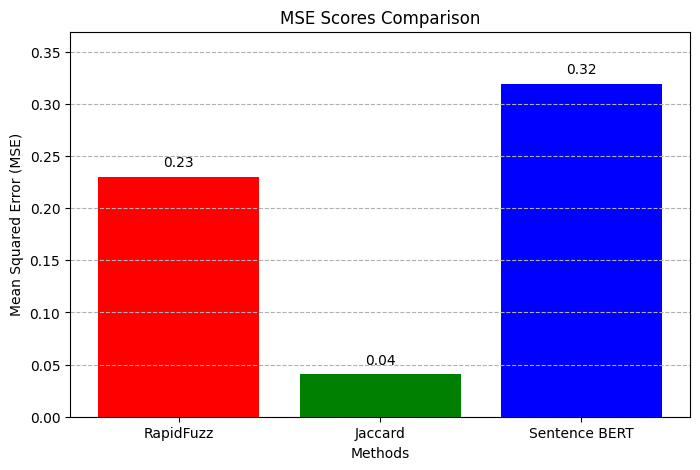

In [81]:
import matplotlib.pyplot as plt

# Sample MSE scores for illustration
mse_scores = {
    'RapidFuzz': mse_value1,
    'Jaccard': mse_value2,
    'Sentence BERT': mse_value3
}



# Plotting
labels = list(mse_scores.keys())
scores = list(mse_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['red', 'green', 'blue'])

# Adding title and labels
plt.title('MSE Scores Comparison')
plt.xlabel('Methods')
plt.ylabel('Mean Squared Error (MSE)')

# Show the values on top of bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center')

plt.ylim(0, max(scores) + 0.05)  # Adjust y-axis limit for better visibility
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()


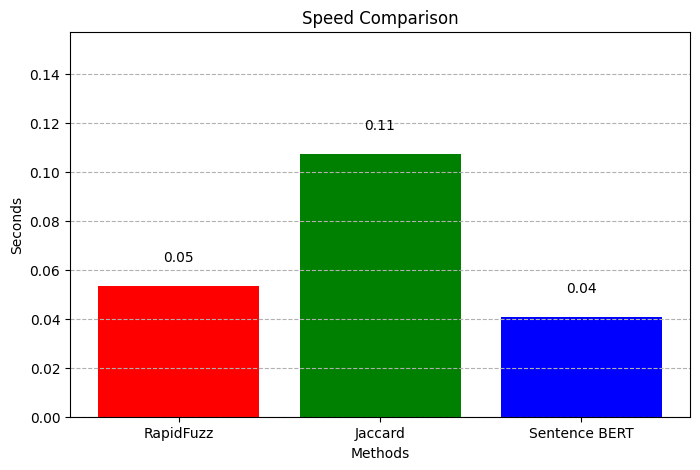

In [82]:
# Sample MSE scores for illustration
mse_scores = {
    'RapidFuzz': t1,
    'Jaccard': t2,
    'Sentence BERT': t3
}

# Plotting
labels = list(mse_scores.keys())
scores = list(mse_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['red', 'green', 'blue'])

# Adding title and labels
plt.title('Speed Comparison')
plt.xlabel('Methods')
plt.ylabel('Seconds')

# Show the values on top of bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center')

plt.ylim(0, max(scores) + 0.05)  # Adjust y-axis limit for better visibility
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()


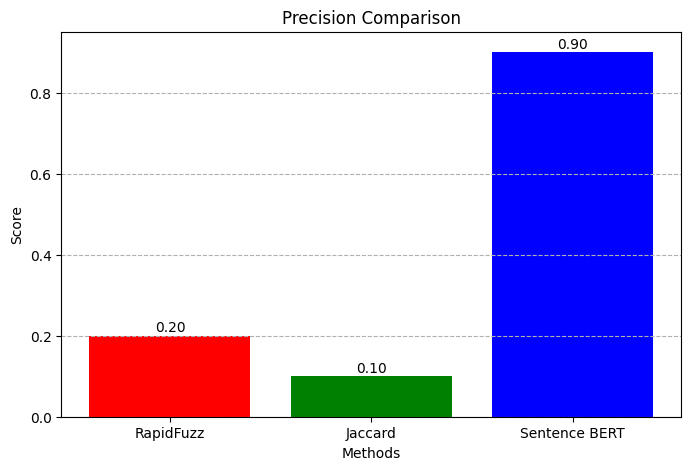

In [83]:
# Sample MSE scores for illustration
mse_scores = {
    'RapidFuzz': precision1,
    'Jaccard': precision2,
    'Sentence BERT': precision3
}

# Plotting
labels = list(mse_scores.keys())
scores = list(mse_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['red', 'green', 'blue'])

# Adding title and labels
plt.title('Precision Comparison')
plt.xlabel('Methods')
plt.ylabel('Score')

# Show the values on top of bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center')

plt.ylim(0, max(scores) + 0.05)  # Adjust y-axis limit for better visibility
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

In [47]:
pip install sentence_transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [48]:
'''from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode_text(texts):
    # Tokenize and encode the texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Return the mean of the hidden states as the embedding
    return outputs.last_hidden_state.mean(dim=1)

# Combine Name and Composition for BERT encoding
df['Combined'] = df['Name'] + ' ' + df['composition']
combined_texts = df['Combined'].tolist()
combined_embeddings = encode_text(combined_texts)

def get_recommendations_bert(input_query, search_type='name', top_n=3):
    if search_type == 'name':
        input_query_combined = input_query + ' '  # Add a space to match the combined format
    else:
        input_query_combined = input_query
    
    input_embedding = encode_text([input_query_combined])
    cosine_sim = cosine_similarity(input_embedding, combined_embeddings)
    
    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim.flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get indices of top N recommendations
    top_indices = [i[0] for i in sim_scores[:top_n]]
    recommendations = df.iloc[top_indices]
    
    return recommendations[['Links-href', 'Name', 'Uses', 'Price', 'Composition', 'Side_effects', 'Status', 'manufacturer']]

# Test the recommender with BERT
input_query = 'Paracetamol'  # or a composition string
search_type = 'composition'  # or 'name'
recommended_drugs = get_recommendations_bert(input_query, search_type=search_type, top_n=10)

print("Recommended Drugs:")
print(recommended_drugs)'''


'from transformers import BertTokenizer, BertModel\nimport torch\nfrom sklearn.metrics.pairwise import cosine_similarity\nimport pandas as pd\n\n\n# Load BERT tokenizer and model\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nmodel = BertModel.from_pretrained(\'bert-base-uncased\')\n\ndef encode_text(texts):\n    # Tokenize and encode the texts\n    inputs = tokenizer(texts, return_tensors=\'pt\', padding=True, truncation=True)\n    with torch.no_grad():\n        outputs = model(**inputs)\n    # Return the mean of the hidden states as the embedding\n    return outputs.last_hidden_state.mean(dim=1)\n\n# Combine Name and Composition for BERT encoding\ndf[\'Combined\'] = df[\'Name\'] + \' \' + df[\'composition\']\ncombined_texts = df[\'Combined\'].tolist()\ncombined_embeddings = encode_text(combined_texts)\n\ndef get_recommendations_bert(input_query, search_type=\'name\', top_n=3):\n    if search_type == \'name\':\n        input_query_combined = input_query + \' \'  # 